In [1]:
!pip install --upgrade imbalanced-learn==0.10.1

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 5.2 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.13.0
    Uninstalling imbalanced-learn-0.13.0:
      Successfully uninstalled imbalanced-learn-0.13.0


2025-11-27 15:56:21.927412: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764258982.353180      20 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764258982.483850      20 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
IMG_SIZE = (256, 256)
BATCH_SIZE = 16
EPOCHS = 100

data_dir = "/kaggle/input/ppmim1/MRI-CONV--v1"
classes = ["NONPD", "PD"]

X, y = [], []

for idx, cls in enumerate(classes):
    class_path = os.path.join(data_dir, cls)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)

        if img is None:
            continue

        img = cv2.resize(img, IMG_SIZE)
        X.append(img)
        y.append(idx)

X = np.array(X, dtype='float32') / 255.0
y = np.array(y)

print("Dataset shape:", dict(zip(*np.unique(y, return_counts=True))))


Dataset shape: {0: 272, 1: 798}


In [3]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [4]:
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.20,
    height_shift_range=0.20,
    zoom_range=0.25,
    shear_range=0.20,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)
val_generator = val_datagen.flow(X_val, y_val, batch_size=BATCH_SIZE)


In [5]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)


Class Weights: {0: 1.963302752293578, 1: 0.670846394984326}


In [6]:
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)

x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)

x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)

output = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


I0000 00:00:1764259007.848290      20 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1764259007.848965      20 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 256, 256,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 256, 256,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 256, 256,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 257, 257,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 128, 128,  │      1,080 │ stem_conv_pad[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 128, 128,  │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 128, 128,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 128, 128,  │        360 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 128, 128,  │        160 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 128, 128,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 40)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 40)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 10)  │        410 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 40)  │        440 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 128, 128,  │          0 │ block1a_activati… │
│ (Multiply)          │ 40)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 128, 128,  │        960 │ block1a_se_excit

 Total params: 11,217,329 (42.79 MB)

 Trainable params: 11,126,442 (42.44 MB)

 Non-trainable params: 90,887 (355.03 KB)

In [7]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.4,
    patience=4,
    verbose=1
)


In [8]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    callbacks=[early_stop, reduce_lr],
    class_weight=class_weights,
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100


I0000 00:00:1764259100.027397      70 service.cc:148] XLA service 0x7e1be8118970 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764259100.028868      70 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1764259100.028928      70 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1764259108.298859      70 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1764259123.100749      70 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1764259123.244067      70 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1764259123.637233      70 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. Th

16/54 ━━━━━━━━━━━━━━━━━━━━ 9s 241ms/step - accuracy: 0.5453 - loss: 0.8792

E0000 00:00:1764259178.259455      67 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1764259178.395771      67 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


54/54 ━━━━━━━━━━━━━━━━━━━━ 225s 2s/step - accuracy: 0.5083 - loss: 0.9986 - val_accuracy: 0.7523 - val_loss: 0.6407 - learning_rate: 1.0000e-04
Epoch 2/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 260ms/step - accuracy: 0.5033 - loss: 0.9605 - val_accuracy: 0.7477 - val_loss: 0.6245 - learning_rate: 1.0000e-04
Epoch 3/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 258ms/step - accuracy: 0.4858 - loss: 0.9264 - val_accuracy: 0.6168 - val_loss: 2282.1187 - learning_rate: 1.0000e-04
Epoch 4/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 262ms/step - accuracy: 0.5189 - loss: 0.9220 - val_accuracy: 0.7103 - val_loss: 0.6202 - learning_rate: 1.0000e-04
Epoch 5/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 15s 275ms/step - accuracy: 0.5227 - loss: 0.9266 - val_accuracy: 0.6215 - val_loss: 9.6093 - learning_rate: 1.0000e-04
Epoch 6/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 263ms/step - accuracy: 0.5277 - loss: 0.8977 - val_accuracy: 0.6542 - val_loss: 2349.4785 - learning_rate: 1.0000e-04
Epoch 7/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 264ms/step - accu

7/7 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step
              precision    recall  f1-score   support

       NONPD       0.36      0.19      0.24        54
          PD       0.76      0.89      0.82       160

    accuracy                           0.71       214
   macro avg       0.56      0.54      0.53       214
weighted avg       0.66      0.71      0.68       214



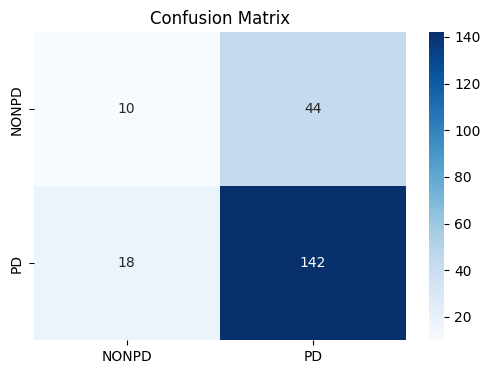

In [9]:
y_pred_prob = model.predict(X_val)
y_pred = np.argmax(y_pred_prob, axis=1)

print(classification_report(y_val, y_pred, target_names=classes))

cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix")
plt.show()


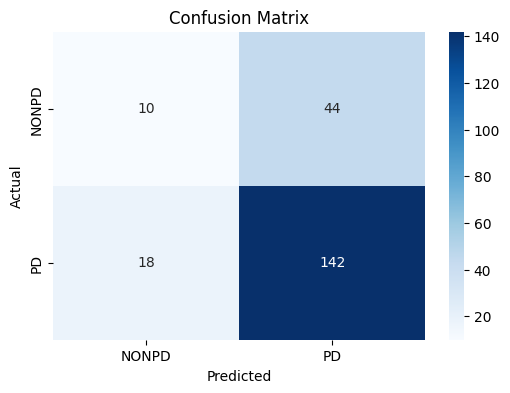

In [10]:
cm = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


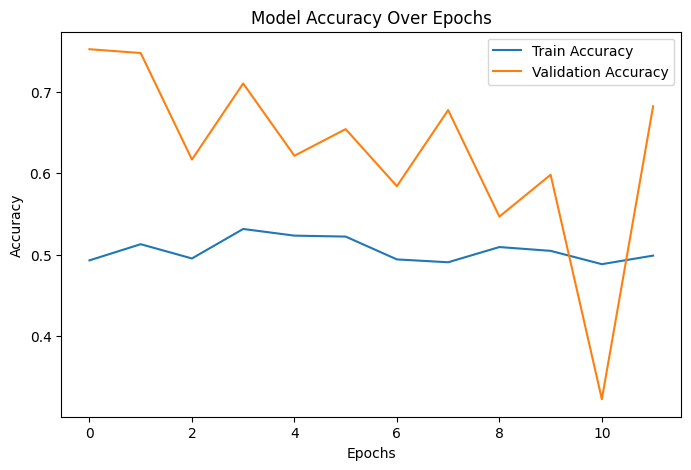

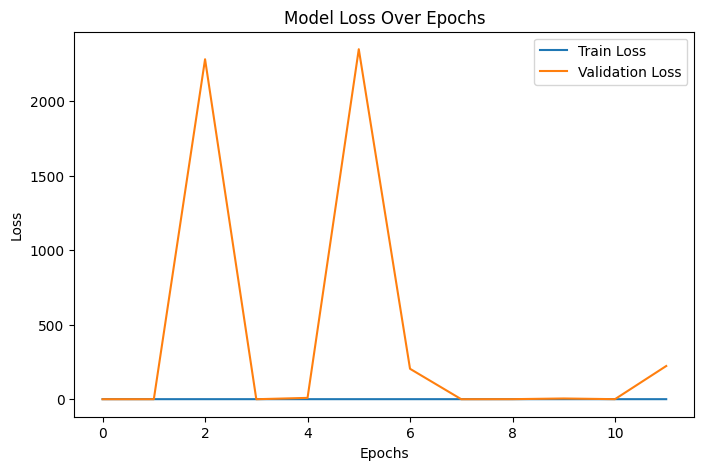

In [11]:
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Model Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Model Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [12]:
data_dir = "/kaggle/input/ppmim1/MRI-CONV--v1"